TODO:

* SSIM check can be added to determine which rotation angle is the best for a rotation angle margin.

* Partition images into 6 sub-images


In [1]:
import time
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-11-14 09:20:00--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15061 (15K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]  14.71K  --.-KB/s    in 0s      

2023-11-14 09:20:00 (49.6 MB/s) - ‘models.py’ saved [15061/15061]

--2023-11-14 09:20:00--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6436 (6.3K) [text/plain]
Savi

In [3]:
from utils import vision
from utils import utils
from utils import losses

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'
BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')

In [6]:
REFERENCE_IMG_DIR = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/reference_img/reference_img.png'

In [7]:
img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_PATH, 'JPG')
rotated_img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_ROTATED_PATH, 'JPG')
testing_img_files = utils.get_image_file_list(BD67_DEFECTED_FRONT_PATH, 'JPG')
all_img_files = img_files + rotated_img_files + testing_img_files

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all testing image files: ", len(testing_img_files))
print("Number of all image files: ", len(all_img_files))

Number of flat image files:  110
Number of rotated image files:  108
Number of all testing image files:  10
Number of all image files:  228


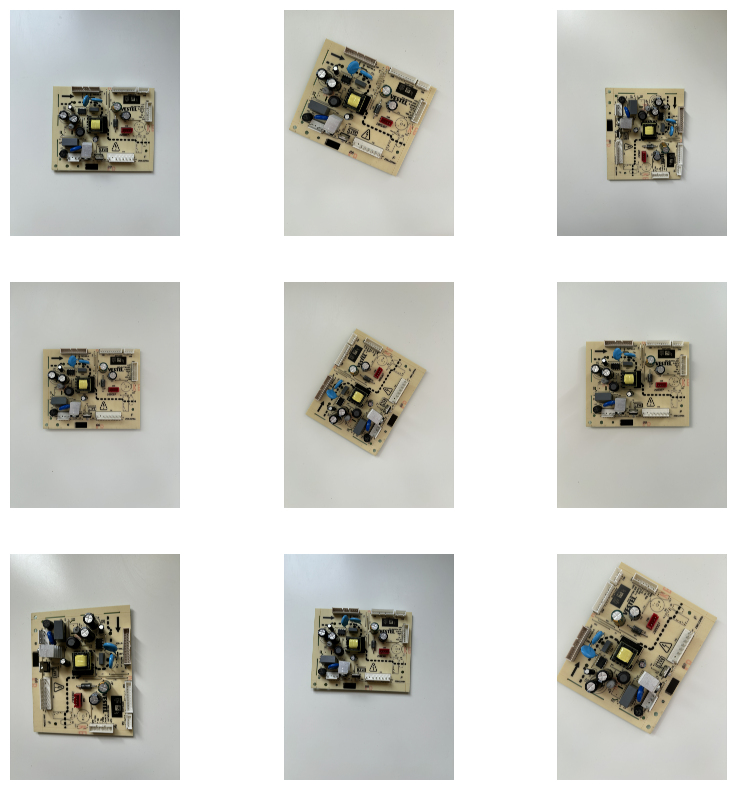

In [8]:
import random

fig = plt.figure(figsize = (10,10))
fig.tight_layout()

for ix in range(9):
  plt.subplot(3, 3, (ix+1))
  plt.imshow(utils.load_images(all_img_files[random.randint(0, (len(all_img_files)-1))], rot=utils.ROT_270))
  plt.axis('off')

plt.show()

In [9]:
sample_img = cv2.imread(all_img_files[0])
print("Sample image shape: ", sample_img.shape)
#sample_img = vision.resize_image_with_aspect_ratio(sample_img, width=800)   # Image size is too large to show
#cv2_imshow(sample_img)

Sample image shape:  (5712, 4284, 3)


Text(0.5, 1.0, 'Reference Image')

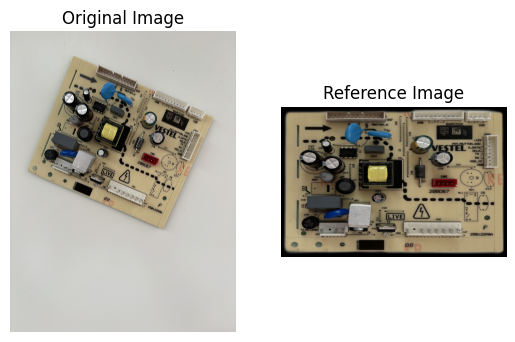

In [10]:
original_image = cv2.cvtColor(cv2.imread(all_img_files[115]), cv2.COLOR_BGR2RGB)
reference_image = cv2.cvtColor(cv2.imread(REFERENCE_IMG_DIR), cv2.COLOR_BGR2RGB)

plt.subplot(1,2,1)
plt.imshow(original_image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(reference_image, cmap='gray')
plt.axis('off')
plt.title('Reference Image')

We should downsize the original image. Image's aspect ratio will be kept.

Resizing Width = sample_img.shape[1] // 2

In [11]:
FLANN_INDEX_KDTREE = 1
MIN_MATCH_COUNT = 10
DISTANCE_FACTOR = 0.75
ROT_MARGIN = 2
REF_IMG_WIDTH = reference_image.shape[1]
REF_IMG_HEIGHT = reference_image.shape[0]
PATCH_SIZE = 512

x_partition = REF_IMG_WIDTH // PATCH_SIZE
y_partition = REF_IMG_HEIGHT // PATCH_SIZE


print("Minimum match count: ", MIN_MATCH_COUNT)
print("Distance (in feature space) Factor: ", DISTANCE_FACTOR)
print("Rotation margin: ", ROT_MARGIN)
print("\nReference Image width: ", REF_IMG_WIDTH)
print("Reference Image height: ", REF_IMG_HEIGHT)
print("\nPatch Size: ", PATCH_SIZE)
print(f"Flattened image x_partition for ({PATCH_SIZE}, {PATCH_SIZE}) image shape: {x_partition}")
print(f"Flattened image y_partition for ({PATCH_SIZE}, {PATCH_SIZE}) image shape: {y_partition}")

Minimum match count:  10
Distance (in feature space) Factor:  0.75
Rotation margin:  2

Reference Image width:  1536
Reference Image height:  1024

Patch Size:  512
Flattened image x_partition for (512, 512) image shape: 3
Flattened image y_partition for (512, 512) image shape: 2


In [13]:
def flatten_object_in_image_and_crop(org_img_file, ref_img_file, dist_factor=0.75, min_matches=4, rot_margin=2, matcher='BF', show=False, save_dir=None):
  '''
  org_img_file: original image file directory
  ref_img_file: reference image file directory
  dist_factor: distance factor for matched features distances. default 0.75.
  min_matches: number of minimum matched features that under distance. default 4.
  rot_margin: rotate image if found rotation angle is upper than rot_margin. default 2.
  matcher: feature matcher algorithm. 'BF' or 'FLANN'   default 'BF'.
  show: show flattened object image. default False.
  save_dir: save new image to the specified directory. default None.
  '''
  rot_degree_margin = 0
  original_image = cv2.imread(org_img_file, cv2.IMREAD_GRAYSCALE)
  reference_image = cv2.imread(ref_img_file, cv2.IMREAD_GRAYSCALE)
  #original_image = vision.resize_image_with_aspect_ratio(original_image, width=(org_img_file.shape[1] // 2))
  #raw_image = vision.resize_image_with_aspect_ratio(cv2.imread(org_img_file), width=(org_img_file.shape[1] // 2))
  raw_image = cv2.imread(org_img_file)

  if save_dir != None:
    print("\nPreprocessed image: ", save_dir.split('/')[-1])

  # Calculate center point of the source and ref image
  height_org, width_org = original_image.shape[:2]
  centerX_org, centerY_org = (width_org // 2, height_org // 2)
  height_ref, width_ref = reference_image.shape[:2]
  centerX_ref, centerY_ref = (width_ref // 2, height_ref // 2)

  # ======= FEATURE EXTRACTION AND MATCHING PART =======
  start_time_train = time.time()  # Get instant time to compute spent time during pre-processing
  # Initiate SIFT detector
  sift = cv2.SIFT_create()

  # Extract features (keypoints and descriptors) with SIFT
  kp1, des1 = sift.detectAndCompute(reference_image, None)
  start_time_test = time.time()  # Get instant time to compute spent time during pre-processing
  kp2, des2 = sift.detectAndCompute(original_image, None)

  # Flann based matcher with 5 trees KD Tree - Preprocessin for test data
  if matcher == 'FLANN':
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
  elif matcher == 'BF':
    # BFMatcher with default params - Preprocessin for training data
    matcher = cv2.BFMatcher()

  matches = matcher.knnMatch(des1,des2,k=2)

  # Store all the good matches as per Lowe's ratio test.
  good = []
  for m,n in matches:
      if m.distance < dist_factor*n.distance:
          good.append(m)

  if len(good) > min_matches:
      # ======= FLATTEN AND CROP IMAGE PART =======
      src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
      # Calculate the transformation matrix
      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

      # Calculate the rotation angle
      rotation_angle = np.arctan2(M[1, 0], M[0, 0])

      # Convert the rotation angle from radians to degrees
      rotation_angle_degrees = int(np.degrees(rotation_angle))-rot_degree_margin
      print("Rotation angle: ", rotation_angle_degrees, end =" ")

      # Create a new transformation matrix to flatten the object
      rot_matrix = cv2.getRotationMatrix2D((centerX_org, centerY_org), (rotation_angle_degrees), 1.0)

      pts = np.float32([[0,0],[0,height_ref-1],[width_ref-1,height_ref-1],[width_ref-1,0]]).reshape(-1,1,2)
      dst = cv2.perspectiveTransform(pts, M)

      # Create a binary mask
      obj_mask = np.zeros_like(raw_image, dtype=np.uint8)
      #cv2.fillPoly(obj_mask, [np.int32(dst)], 255)  #'Gray'
      cv2.fillPoly(obj_mask, [np.int32(dst)], color=(255, 255, 255))   #'RGB'

      # Apply the mask to the original image to extract the object
      obj_img = cv2.bitwise_and(raw_image, obj_mask)
      if abs(rotation_angle_degrees) > rot_margin:
        print("- Rotated")
        flattened_image = cv2.warpAffine(obj_img, rot_matrix, (width_org, height_org))
      else:
        print("- Did not Rotated")
        flattened_image = obj_img

      #sample_img = cv2.polylines(original_image, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

      # Initiate FAST object with default values
      fast = cv2.FastFeatureDetector_create()

      # find and draw the keypoints
      flattened_image_gray = cv2.cvtColor(flattened_image, cv2.COLOR_RGB2GRAY)
      kp = fast.detect(flattened_image_gray, None)
      #corner_img = cv2.drawKeypoints(flattened_image, kp, None, color=(255,0,0))
      #corner_pts = np.float32([kp[m.queryIdx].pt for m in good]).reshape(-1,1,2)

      # Get bounding box coordinates for keypoints
      x1, y1, x2, y2 = float('inf'), float('inf'), float('-inf'), float('-inf')

      for keypoint in kp:
        x, y = keypoint.pt
        x1 = int(min(x1, x))
        y1 = int(min(y1, y))
        x2 = int(max(x2, x))
        y2 = int(max(y2, y))

      print(f"(x1,y1): ({x1},{y1}) - (x2,y2): ({x2},{y2})")

      flattened_image = flattened_image[int(y1):int(y2), int(x1):int(x2)]
      end_time = time.time()    # Get instant time to compute spent time during pre-processing
      print("Cropped image shape: ", flattened_image.shape)
      # Resize image to size of reference image
      flattened_image = cv2.resize(flattened_image, (reference_image.shape[1], reference_image.shape[0]))
      print("Reference image shape: ", flattened_image.shape)
      print("Execution time for pre-processing: ", (end_time - start_time_test))

      if show:
        cv2_imshow(flattened_image)
      if save_dir != None:
        cv2.imwrite(save_dir, flattened_image)
      return flattened_image
  else:
      print(f"Not enough good matches found for minimum match count {min_matches}. More similar reference image is needed")
      return 0

Rotation angle:  23 - Rotated
(x1,y1): (246,895) - (x2,y2): (3310,3480)
Cropped image shape:  (2585, 3064, 3)
Reference image shape:  (1024, 1536, 3)
Execution time for pre-processing:  9.210870742797852


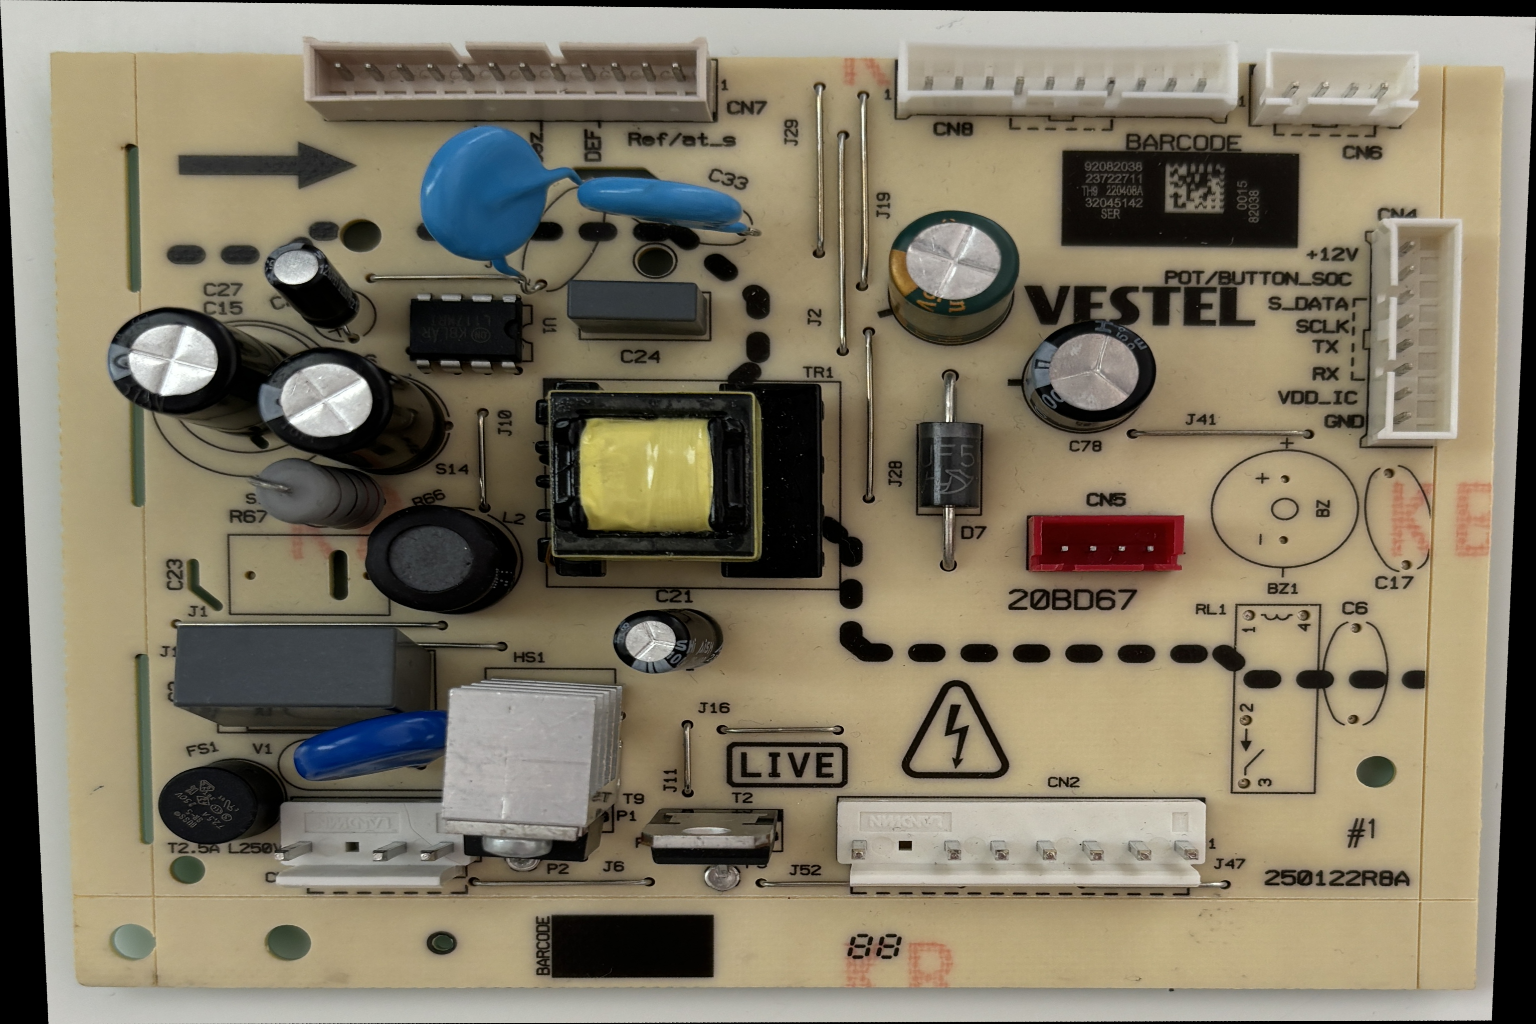

In [14]:
flattened_image = flatten_object_in_image_and_crop(all_img_files[115], REFERENCE_IMG_DIR, dist_factor=DISTANCE_FACTOR, min_matches=MIN_MATCH_COUNT, show=True, rot_margin=ROT_MARGIN)

Text(0.5, 1.0, 'Reference Image')

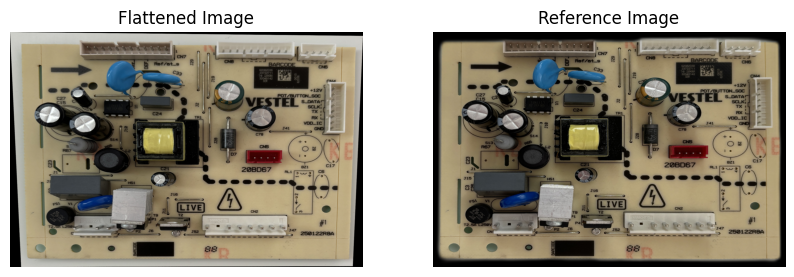

In [15]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(flattened_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Flattened Image')
plt.subplot(1,2,2)
plt.imshow(reference_image)
plt.axis('off')
plt.title('Reference Image')

In [ ]:
losses.ssim_loss(flattened_image, reference_image)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9859768>

### Patchify Image

In [ ]:
! pip install patchify

In [ ]:
from patchify import patchify
from patchify import unpatchify
from PIL import Image

In [ ]:
def patchify_images(images, patch_size=256, scl=False, cvt_rgb=False, verbose=0):
    '''
    img_file_list: Takes image files' paths as input
    patch_size: Divides all images to speicifed patch size
    img_size: Resize images before patchify
    method: Partitioning method -> 'CROP' or 'RESIZE'
    scl: Scales images
    cvt_rgb: Convert BGR decoding to RGB format
    Return: Image numpy array

    Need patchify package (https://pypi.org/project/patchify/)
    ! pip install patchify
    Modified code of Dr. Sreenivas Bhattiprolu
    '''
    image_dataset = []

    for image in images:
      if cvt_rgb == True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      SIZE_X = (image.shape[1]//patch_size)*patch_size # Nearest size divisible by specified patch size
      SIZE_Y = (image.shape[0]//patch_size)*patch_size # Nearest size divisible by specified patch size
      image = Image.fromarray(image)
      image = image.crop((0 ,0, SIZE_X, SIZE_Y))  # Crop from top left corner
      image = np.array(image)
      patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step = patch_size for patch_size patches means no overlap

      for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = single_patch_img[0] # No need to other dimensions.
            image_dataset.append(single_patch_img)

    return np.array(image_dataset)

In [ ]:
flattened_image_batch = np.expand_dims(flattened_image, axis=0)
flattened_image_batch.shape

(1, 1024, 1536, 3)

In [ ]:
partitioned_images = patchify_images(flattened_image_batch, patch_size=PATCH_SIZE, cvt_rgb=True)

Visualize partitioned image

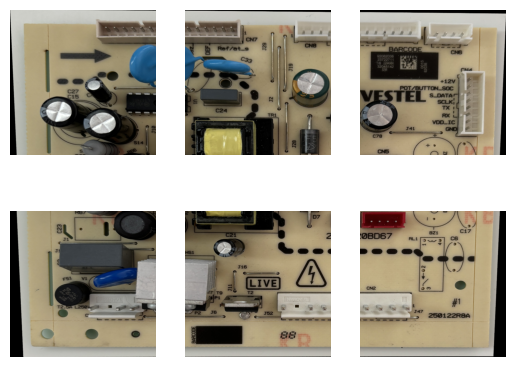

In [ ]:
for ix in range(x_partition*y_partition):
  plt.subplot(y_partition, x_partition, (ix+1))
  plt.imshow(partitioned_images[ix])
  plt.axis('off')

plt.show()

In [ ]:
def unpatchify_img(patches, grid):
  cols, rows = grid[0], grid[1]
  patch_list = []
  num_col_patches = 0

  for row_ix in range(rows):
    patch_list.append(patches[num_col_patches])
    for col_ix in range(cols-1):
      patch_list[row_ix] = np.concatenate((patch_list[row_ix], patches[num_col_patches+1+col_ix]), axis=1)
    num_col_patches += cols
    if row_ix == 0:
      image = patch_list[row_ix]
    else:
      image = np.concatenate((image, patch_list[row_ix]), axis=0)

  return image

In [ ]:
res = unpatchify_img(partitioned_images[:6], grid=(3,2))

(-0.5, 1535.5, 1023.5, -0.5)

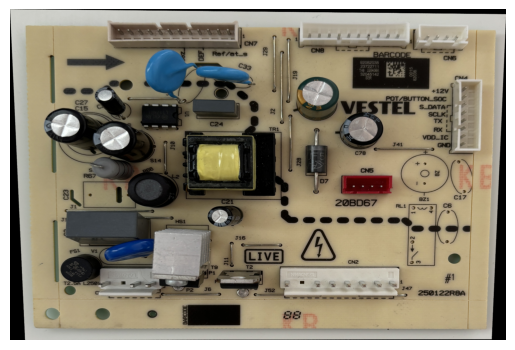

In [ ]:
plt.imshow(res)
plt.axis('off')

Save partitioned images into grid folders for one image

In [ ]:
save_grid_dir_base = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/partitioned/grid_'

flattened_image = flatten_object_in_image_and_crop(img_files[0], REFERENCE_IMG_DIR, dist_factor=DISTANCE_FACTOR, min_matches=MIN_MATCH_COUNT, show=False, rot_margin=ROT_MARGIN)
flattened_image_batch = np.expand_dims(flattened_image, axis=0)
partitioned_images = patchify_images(flattened_image_batch, patch_size=PATCH_SIZE, cvt_rgb=False)

for grid, partitioned_image in enumerate(partitioned_images):
  save_dir = save_grid_dir_base + str(grid) + "/" + str(img_files[0][-12:-4]) + "_partitioned" + ".png"
  cv2.imwrite(save_dir, partitioned_image)

Rotation angle:  0 - Did not Rotated
(x1,y1): (785,1515) - (x2,y2): (3291,3582)
Cropped image shape:  (2067, 2506, 3)
Reference image shape:  (1024, 1536, 3)
Execution time for pre-processing:  10.567063808441162


Unpatchify stored image from dataset

(-0.5, 1535.5, 1023.5, -0.5)

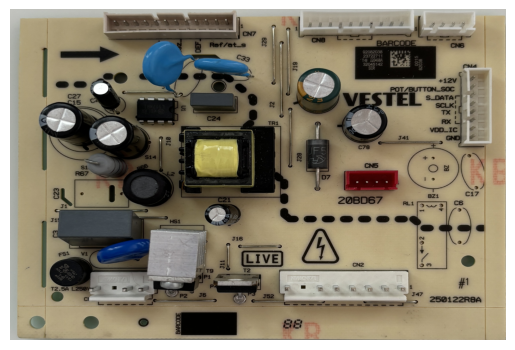

In [ ]:
grids = 6
partitioned_images = []

for grid in range(grids):
  img_dir = save_grid_dir_base + str(grid) + "/" + str(img_files[0][-12:-4]) + "_partitioned" + ".png"
  partitioned_images.append(cv2.cvtColor(cv2.imread(img_dir), cv2.COLOR_BGR2RGB))

res = unpatchify_img(partitioned_images[:grids], grid=(3,2))

plt.imshow(res)
plt.axis('off')

Automation - Apply methods to all dataset

In [ ]:
save_grid_dir_base = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defected/Front/partitioned/grad_'

for image_file in testing_img_files:
  flattened_image = flatten_object_in_image_and_crop(image_file, REFERENCE_IMG_DIR, dist_factor=DISTANCE_FACTOR, min_matches=MIN_MATCH_COUNT, show=False, rot_margin=ROT_MARGIN)
  partitioned_images = patchify_images(np.expand_dims(flattened_image, axis=0), patch_size=PATCH_SIZE, cvt_rgb=False)

  for grid, partitioned_image in enumerate(partitioned_images):
    save_dir = save_grid_dir_base + str(grid) + "/" + str(image_file[-12:-4]) + "_partitioned" + ".png"
    cv2.imwrite(save_dir, partitioned_image)

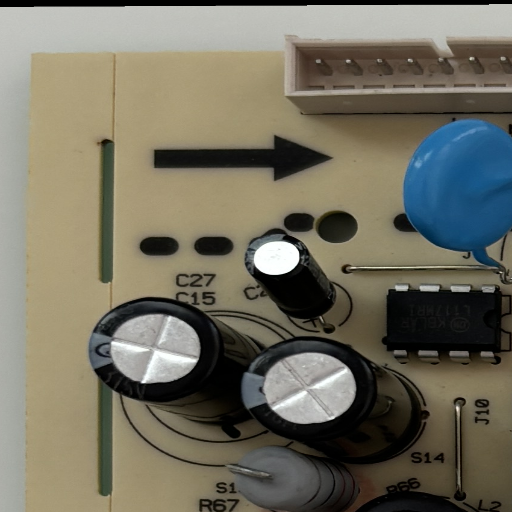

In [ ]:
sample_file = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/partitioned/grid_0/' + str(img_files[0][-12:-4]) + "_partitioned" + ".png"

sample = cv2.imread(sample_file)
cv2_imshow(sample)

Reference:

https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html

https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

https://docs.opencv.org/4.x/df/d0c/tutorial_py_fast.html

https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html

